# import

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy import stats
from math import ceil
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import bootstrapped.compare_functions as bs_compare
import statsmodels.stats.api as sms
import statsmodels.stats.proportion as proportion
import statsmodels.stats.power as smp
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline


In [46]:
df = pd.read_csv('ab_data.csv')
print(f'shape: {df.shape}')
df.head()

shape: (294478, 5)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


посмотрим, сколько длился данный эксперимент:

In [47]:
df.timestamp = df.timestamp.apply(lambda x: x.split(' ')[0])

In [48]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y/%m/%d")
df['timestamp'].max()  - df['timestamp'].min()

Timedelta('22 days 00:00:00')

Timedelta('22 days 00:00:00')

Уберём тех пользователей, которые есть одновременно в обеих группах, так как нам нужны и этого требует стат.критерии - независимость рассматриваемых групп

In [49]:
double_person = df['user_id'].value_counts()
users_to_drop = double_person[double_person>1].index
print(f'количество человек, которые есть и в контрольной группе и тестовой : {len(users_to_drop)}')

количество человек, которые есть и в контрольной группе и тестовой : 3894


количество человек, которые есть и в контрольной группе и тестовой : 3894

In [50]:
df = df[~df['user_id'].isin(users_to_drop)]
df.shape

(286690, 5)

In [51]:
# посмотрим на кол-во людей в каждой из групп
pd.crosstab(df.group, df.landing_page)

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


In [52]:
# сгруппируем по старому/новому дизайну и применим к колонке conversed агрегирующие фун-иии
se = lambda x: stats.sem(x, ddof=0)
summury_stats = df.groupby('group')['converted'].agg(['mean', 'std', se, 'count'])
summury_stats.rename(columns={'<lambda_0>': 'std error', 'mean': 'conversion'}, inplace=True)
summury_stats

,conversion,std,std error,count
group,,,,
control,0.120173,0.325165,0.000859,143293
treatment,0.118726,0.323467,0.000854,143397


# Chisquared-test for conversion

In [53]:
def chi_test(df):
    
    control = df[df.group=='control']['converted']
    treatment = df[df.group=='treatment']['converted']
    success = [control.sum(), treatment.sum()]
    counts = [control.count(), treatment.count()]
    
    chi_stat, pvalue, table = proportion.proportions_chisquare(count=success, nobs=counts)
    
    print(f'chi-statistic : {round(chi_stat,3)}\np-value : {round(pvalue, 3)}')
    if pvalue>0.01:
        print('различия между двумя группами статистически не значимы, следовательно конверсии двух групп не различаются')
    else:
        print('различия между двумя группами статистически значимы, следовательно конверсии двух групп различаются')

    
    return round(pvalue, 3)


pvalue = chi_test(df)




chi-statistic : 1.427
p-value : 0.232
различия между двумя группами статистически не значимы, следовательно конверсии двух групп не различаются


 - chi-statistic : 1.427
 - p-value : 0.232
 - различия между двумя группами статистически не значимы, следовательно конверсии двух групп не различаются

# Creating synthetic column 'first_buy'

Ниже я создам искусственно колонку, в которой будут данные о первой покупке пользователей.
Я моделирую ситацию, в которой мы проверяем не только конверсию как таковую, но ещё и средний чек в обоих группах и далее
комплексно принимаю решение - какой дизайн лучше для бизнеса
Причём данные для контрольной и тестовой групп будут отличаться cредним и дисперсией.
Данные будут распределены нормально.

In [54]:
control_user = df[(df.group=='control') & (df.converted==1)]['user_id']
treat_user = df[(df.group=='treatment') & (df.converted==1)]['user_id']

contr_df = pd.DataFrame({'user_id' : control_user}).reset_index(drop=True)
contr_df.index.name = 'index'
treat_df = pd.DataFrame({'user_id' : treat_user}).reset_index(drop=True)
treat_df.index.name = 'index'

len_contr = len(contr_df)
len_treat = len(treat_df)


In [55]:
random.seed(11)
control_first_buy = np.random.normal(610,200,(len_contr,1))
treatment_first_buy = np.random.normal(660,180,(len_treat,1))
control_first_buy = control_first_buy.reshape(-1)
treatment_first_buy = treatment_first_buy.reshape(-1)

control_df = pd.DataFrame({'first_buy' : control_first_buy, 'group' : 'control', 'converted':1}).reset_index(drop=True)
control_df.index.name = 'index'
treatment_df = pd.DataFrame({'first_buy' : treatment_first_buy, 'group' : 'treatment', 'converted':1}).reset_index(drop=True)
treatment_df.index.name = 'index'


control_df = pd.concat([contr_df,control_df], axis=1)
treatment_df = pd.concat([treat_df,treatment_df], axis=1)

union_df = pd.concat([control_df, treatment_df])


In [56]:
union_df['first_buy'] = union_df['first_buy'].apply(lambda x: ceil(x))
union_df

,user_id,first_buy,group,converted
index,,,,
0,864975,751,control,1
1,644214,828,control,1
2,913579,647,control,1
3,831737,1023,control,1
4,862225,549,control,1
...,...,...,...,...
17020,653524,354,treatment,1
17021,919617,1001,treatment,1
17022,757646,977,treatment,1


In [57]:
# сбрасываем не нужные нам колонки
df.drop(['timestamp', 'landing_page'], axis=1, inplace=True)

In [58]:
df_full = pd.merge(df, union_df, how='left')
df_full.head()

,user_id,group,converted,first_buy
0,851104,control,0,NaN
1,804228,control,0,NaN
2,661590,treatment,0,NaN
3,853541,treatment,0,NaN
4,864975,control,1,751.0


# Bootstrap and AOV mertic

Создаём два массива с первыми покупками у контрольной и тестовой группы, знач-я NaN сбрасываем, так как нам нужно выявить разницу (если она есть) между средним чеком в обоих группах.

Для этого будем использовать метод Bootstrap, который будет множество раз делать подвыборки из контрольной и тестовой групп с возвращеним, далее сравниваем средние значения групп(т.е. средний чек) между собой (мы будем искать их разницу), и наконец полученную разницу сохранять в массив.

После всего этого мы можем построить Bootstrap-распределение полученных знач-й и для этого распределения построить доверительный интервал (99 %). Если в данный интвервал попадает 0 - то значимых различий в среднем чеке нету у рассматриваемых групп.


In [59]:
control_first_buy = df_full[df_full.group=='control']['first_buy'].dropna().values
treat_first_buy = df_full[df_full.group=='treatment']['first_buy'].dropna().values

In [60]:
random.seed(11)
boot_res = bs.bootstrap_ab(test = treat_first_buy,
                           ctrl = control_first_buy,
                           stat_func = bs_stats.mean,
                           compare_func = bs_compare.difference,
                           return_distribution = True)

In [61]:
borders = np.percentile(boot_res, [0.5, 99.5])
print(f'границы нашего доверительного интервала : {borders}')

границы нашего доверительного интервала : [46.18891236 56.75687744]


границы нашего доверительного интервала : [46.18891236 56.75687744]

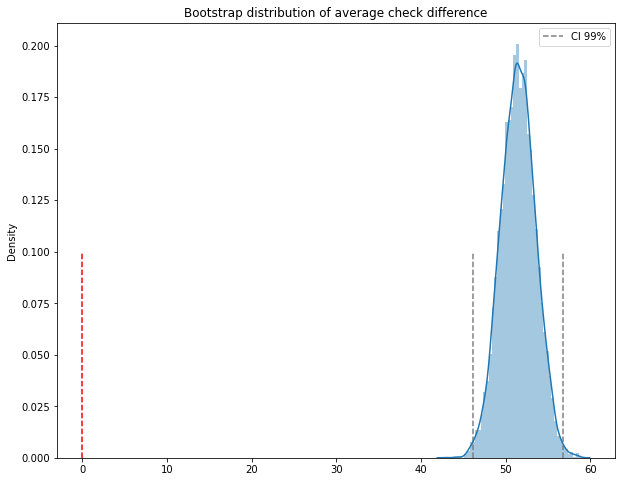

In [69]:
plt.figure(figsize=(10,8))
sns.distplot(boot_res)
plt.title('Bootstrap distribution of average check difference')
plt.vlines(0, ymin=0, ymax=0.1, linestyles='--', color='red')
plt.vlines(borders, ymin=0, ymax=0.1, linestyles='--', color='grey', label='CI 99%')
plt.legend()
plt.show()

## Как видим, в наш 99% доверительной интвервал Bootstrap-распределения знач-е 0 не входит и, сделовательно, мы можем говорить, что присутствует статистическая значимая разница в средних чеках контрольной и тестовой групп - в данном примере видим, что показатели среднего чека тестовой группы выше и мы можем говорить, что это разница заключена в определённый интервал и мы можем ошибиться в 1% наблюдений


# ARPU metric 
# Bootstrap and t-test

Теперь приступим к оценке следующей метрики - ARPU.
Статистическую значимую разницу метрик двух групп я буду оценивать двумя способами - bootstrap и t-testом.
Исходя из того, что наши пользователи независимы - распределение средних нашей метрики будет близко к нормальному, что далее я покажу с помощью bootstrap. Нормальное распределение средних метрики является одним из главных условий применимости т-теста, а не нормальное распределение самой метрики

In [70]:
df_full.fillna(0, inplace=True)
ctrl_cheсks = df_full[df_full.group=='control']['first_buy'].values
treat_cheсks = df_full[df_full.group=='treatment']['first_buy'].values
                                       

In [71]:
bootstrap_ctrl_arpu = bs.bootstrap(ctrl_cheсks,
                           stat_func = bs_stats.mean,
                           return_distribution = True)

bootstrap_threat_arpu = bs.bootstrap(treat_cheсks,
                           stat_func = bs_stats.mean,
                           return_distribution = True)

In [72]:
borders_ctrl = np.percentile(bootstrap_ctrl_arpu, [0.5, 99.5])
borders_treat = np.percentile(bootstrap_threat_arpu, [0.5, 99.5])

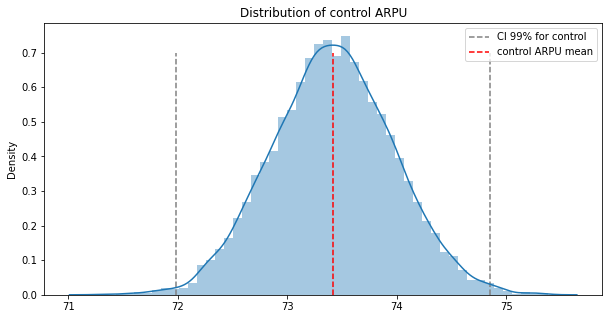

In [74]:
plt.figure(figsize=(10,5))
sns.distplot(bootstrap_ctrl_arpu)
plt.title('Distribution of control ARPU')
plt.vlines(borders_ctrl, ymin=0, ymax=0.7, linestyles='--', color='grey', label='CI 99% for control')
plt.vlines(bootstrap_ctrl_arpu.mean(), ymin=0, ymax=0.7, linestyles='--', color='red', label='control ARPU mean')
plt.legend()
plt.show()

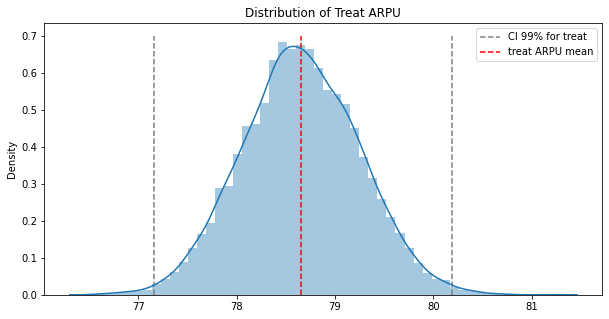

In [75]:
plt.figure(figsize=(10,5))
sns.distplot(bootstrap_threat_arpu)
plt.title('Distribution of Treat ARPU')
plt.vlines(borders_treat, ymin=0, ymax=0.7, linestyles='--', color='grey', label='CI 99% for treat')
plt.vlines(bootstrap_threat_arpu.mean(), ymin=0, ymax=0.7, linestyles='--', color='red', label='treat ARPU mean')
plt.legend()
plt.show()

Как видим, наши 99%-доверительные интервалы не пересекаются - это указывает на тот факт, что метрики в двух группах статистически значимо отличаются друг от друга и можем заключить, что средние значение метрики тестовой группы > контрольной.
Теперь взглянем на результат т-теста:

In [76]:
# но сначала проверим гипотезу о равенстве дисперсий групп, будем использовать тест Левене:

levenetest = stats.levene(ctrl_cheсks, treat_cheсks)[1]
levenetest < 0.01

True

True

отвергаем нулевую гипотезу о равенстве дисперсий двух групп и с этой информацией применяем т-тест:
используем односторонний т-критерий и в качестве альтернативной гипотезы рассматриваем, что среднее знач-е тестовой группы > контрольной


In [77]:
ttest = stats.ttest_ind(treat_cheсks, 
                        ctrl_cheсks, 
                        equal_var=False, 
                        alternative='greater')[1]
ttest < 0.01

True

True

Мы получили статистически значимое различие средних двух групп (метрик ARPU) и при уровне значимости 0.01 отвергаем нулевую гипотезу о равенстве средних и принимаем гипотезу о том, что ARPU тестовой группы > контрольной

##  Как видим, и bootstrap и t-test показывают статистически значимые различия метрики ARPU  у двух групп и мы с 99% вероятностью можем утвеждать, что ARPU тестовой группы > контрольной

# Мощность теста
Это вероятность увидеть различия там, где они действительно есть.
Вычислим мощность для нашего теста конверсии (в нашем случает для стат.критерия хи-квадрат)

In [78]:
# вспомним, как выглядит наша конверсия в обоих группах
summury_stats

,conversion,std,std error,count
group,,,,
control,0.120173,0.325165,0.000859,143293
treatment,0.118726,0.323467,0.000854,143397


In [79]:
chipower = smp.GofChisquarePower()
conversion_control = summury_stats['conversion'][0]
treat_control = summury_stats['conversion'][1]

# так как группы немного отличаются по размеру наблюдений - возьмём размер наименьшей группы в качестве размера наблюдений
nobs = min(summury_stats['count'])


In [80]:
# далее вычислим effect size

def effect_size_chi(p0,p1):
    return np.sqrt((p0-p1)**2 / p0)


У любого стат.критерия аналитически связаны между собой размер эффекта, выборки, уровень значимости и мощность.
Поэтому, зная три параметра - всегда можно найти четвёртый.
Найдём мощность:

In [81]:
chipower.solve_power(effect_size=effect_size_chi(conversion_control, treat_control),
                     nobs=nobs,
                     alpha=pvalue,
                     power=None)



0.6525901752696832

0.6525901752696832

## Мощность 0.65 - это достаточно слабый результат, по сравнению с общепринятыми стандартами: 0.8 и выше. Это значит, мы плохо будем определять различия там, где они действительно есть и будем часто отвергать нулевую гипотезу, где это не нужно

# Вычислим количество наблюдений, необходимых для получения желаемого уровня мощности

In [82]:
# тут параметр устанавливаем 0.05, как желаемый - поскольку мы проводим теоритические вычисления и мы не знаем, 
# какой достигаемый уровень значимости у нас получится в эксперименте
power =0.8
size_for_one_group = chipower.solve_power(effect_size=effect_size_chi(conversion_control, treat_control),
                     nobs=None,
                     alpha=0.05,
                     power=power)
print(f'Требуемое кол-во наблюдений для эксперимента, чтобы обеспечить мощность теста = 0.8: {ceil(2*size_for_one_group)}')

Требуемое кол-во наблюдений для эксперимента, чтобы обеспечить мощность теста = 0.8: 900943


Требуемое кол-во наблюдений для эксперимента, чтобы обеспечить мощность теста = 0.8: 900943

Чтобы набрать требуемое кол-во наблюдений нам понадобится ЕЩЁ 47 дней ожидания эксперимента:
текущий эксперимент длится 22 дня и 286690 наблюдений, а нам нужно (x)дней и 900943 наблюдений

С моей точки зрения набирать ещё наблюдения, чтобы повысить мощность теста - не кажется рациональным,
разница между конверсиями столь мала, что мы можем её и не увидеть при заданом уровне значимости и мощности теста (минимальный обнаруживаемый эффект). Так как мы комплексно смотрим на изменение метрик, то перейдём к выводам.

# Summary

##  Какие выводы мы можем сделать насчёт того - оставлять нам новый дизайн или нет? Если рассматривать в качестве метрики - конверсию в покупку, то статитистически значимых различий у нас нет, а вот если мы рассматриваем средний чек и ARPU, то видим, что они выше  в тестовой группе. Получается, с такой же конверсией как и была, бизнес стал зарабатывать больше с каждого клиента в тестовой группе. Следовательно оставляем новый дизайн и делаем деньги)
